In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


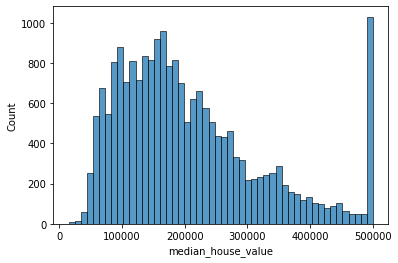

In [4]:
sns.histplot(df['median_house_value'], bins=50)

## Selecting features

In [5]:
del df['ocean_proximity']

#1. Find a feature with missing values. How many missing values does it have?

In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

Feature total_bedrooms has missing values. It has 207 missing values.

#2. What's the median (50% percentile) for variable 'population'?

In [7]:
df['population'].median()

1166.0

##Split the data

Shuffle the initial dataset, use seed 42.

Split your data in train/val/test sets, with 60%/20%/20% distribution.

Make sure that the target value ('median_house_value') is not in your dataframe.

Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [8]:
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [9]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [10]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [11]:
df_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9221,-120.26,37.13,33.0,1239.0,250.0,648.0,227.0,2.0278,58800.0
10234,-117.91,33.86,26.0,2296.0,570.0,1415.0,527.0,2.4732,165800.0
4763,-118.36,34.04,48.0,1769.0,429.0,993.0,405.0,2.3214,139400.0
9062,-118.15,34.69,32.0,1300.0,234.0,712.0,249.0,3.2500,107500.0
1874,-119.97,38.93,24.0,856.0,185.0,388.0,108.0,3.1806,107200.0


In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [14]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

#3.

We need to deal with missing values for the column from Q1.

We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons.

For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.

Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?

In [15]:
check=["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", 
       "population", "households", "median_income"]

def prepare_X(df, fillna_value):
    df_num = df[check]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

In [16]:
def rmse(y, y_pred):
    se = (y_pred - y) ** 2
    mse = se.mean()
    rmse = np.sqrt(mse)
    return rmse

In [17]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [18]:
mean = df_train.total_bedrooms.mean()

X_mean_train = prepare_X(df_train, fillna_value=mean)
w0_mean, w_mean = train_linear_regression(X_mean_train, y_train)

X_mean_val = prepare_X(df_val, fillna_value=mean)
y_mean_pred_val = w0_mean + X_mean_val.dot(w_mean)

In [19]:
np.round(rmse(y_val, y_mean_pred_val), 2)

0.33

In [20]:
X_null_train = prepare_X(df_train, fillna_value=0)
w0_null, w_null = train_linear_regression(X_null_train, y_train)

X_null_val = prepare_X(df_val, fillna_value=0)
y_null_pred_val = w0_null + X_null_val.dot(w_null)

In [21]:
np.round(rmse(y_val, y_null_pred_val), 2)

0.33

Both are same.

#4. 
Now let's train a regularized linear regression.

For this question, fill the NAs with 0.

Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].

Use RMSE to evaluate the model on the validation dataset.

Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE?

In [22]:
def train_linear_regression_reg(X, y, r=0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [23]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_null_train, y_train, r=r)
    y_null_reg_val = w0 + X_null_val.dot(w)
    rmse_val = np.round(rmse(y_val, y_null_reg_val), 2)
    print(r, w0, rmse_val)

0 -11.686975242036546 0.33
1e-06 -11.686959175728921 0.33
0.0001 -11.685368865034667 0.33
0.001 -11.670931317799797 0.33
0.01 -11.528493585632091 0.33
0.1 -10.274500282195673 0.33
1 -4.920480897742212 0.33
5 -1.482095745621172 0.34
10 -0.7899311831779245 0.34


Best value is r = 0

#5. 
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.

Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

For each seed, do the train/validation/test split with 60%/20%/20% distribution.

Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.

Round the result to 3 decimal digits (round(std, 3))

In [24]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [27]:
rmse_list = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    X_null_train = prepare_X(df_train, fillna_value=0)
    w0, w = train_linear_regression(X_null_train, y_train)
    
    X_null_val = prepare_X(df_val, fillna_value=0)
    y_null_pred_val = w0 + X_null_val.dot(w)

    rmse_val = np.round(rmse(y_null_pred_val, y_val), 2)

    rmse_list.append(rmse_val)

print(rmse_list)

[0.34, 0.34, 0.33, 0.34, 0.34, 0.34, 0.35, 0.34, 0.35, 0.34]


In [28]:
np.round(np.std(rmse_list), 3)

0.005

#6.
Split the dataset like previously, use seed 9.

Combine train and validation datasets.

Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

In [30]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

df_full_train = pd.concat([df_train, df_val])
y_full_train = np.concatenate([y_train, y_val])

X_null_train = prepare_X(df_full_train, fillna_value=0)
w0, w = train_linear_regression_reg(X_null_train, y_full_train, r=0.001)
    
X_null_test = prepare_X(df_test, fillna_value=0)
y_null_pred_test = w0 + X_null_test.dot(w)

np.round(rmse(y_null_pred_test, y_test), 2)

0.35